In [ ]:
from src.rag_app.setup.setup_rag import RAGSetup

# rag_setup = RAGSetup()
# rag_setup.run()

In [ ]:
# building rag

In [ ]:
from src.rag_app.chain import RAGChain

rag_chain = RAGChain(retriever_mode = "ensemble")
query = "Dame información sobre la ayuda 'proyectos de i+d'"
response = rag_chain.invoke(query)
print(response)

In [ ]:
# SQL retrieval

In [1]:
import os
from dotenv import load_dotenv

from langchain_community.utilities import SQLDatabase
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI



# 1. Configuración de Azure OpenAI

# 2. Conectar a la base de datos SQLite
from src.processing.params import (
    PROCESSING_OUTPUT_DIR, 
    RAG_DATA_PATH, 
    SQLITE_DATA_PATH, 
    SQLITE_FILE_NAME
)


sqlite_path = f"{RAG_DATA_PATH}/{SQLITE_DATA_PATH}/{SQLITE_FILE_NAME}"

uri = f"sqlite:///{sqlite_path}"
db = SQLDatabase.from_uri(uri)

# 3. Inicializar LLM de Azure OpenAI
load_dotenv()
api_key = os.getenv("AZURE_OPENAI_API_KEY")
api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
deployment = os.getenv("03_MINI_DEPLOYMENT")  # nombre del *deployment*, NO del modelo
api_version = os.getenv("AZURE_OPENAI_API_VERSION")  # Ajusta según la versión de tu Azure OpenAI

llm = AzureChatOpenAI(
    openai_api_key=api_key,
    azure_endpoint=api_base,
    deployment_name=deployment,
    api_version=api_version,
    # temperature=0
)

# 4. Crear el agente con acceso a SQL
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(llm=llm, toolkit=toolkit, verbose=False)



In [2]:
# 5. Ejecutar una pregunta en lenguaje natural
pregunta = "Dame una lista de las tablas de la base de datos"
respuesta = agent_executor.invoke(pregunta)

print("\nRespuesta:")
print(respuesta)


Respuesta:
{'input': 'Dame una lista de las tablas de la base de datos', 'output': 'La base de datos tiene la siguiente tabla: aids_table.'}


In [1]:
from src.rag_app.sql_retrieval import SQLRetrieval

sql_retrieval = SQLRetrieval()
query = "Dame una lista de las tablas de la base de datos"
response = sql_retrieval.invoke(query)
print(response)

La base de datos contiene la siguiente tabla: aids_table.


In [7]:
pregunta = "Cuantas ayudas hay en la tabla aids_table"
respuesta = agent_executor.invoke(pregunta)

print("\nRespuesta:")
print(respuesta)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: aids_tableThought: I'll count the number of rows in the aids_table using an SQL count query.

Action: sql_db_query_checker
Action Input: SELECT COUNT(*) AS total FROM aids_table;SELECT COUNT(*) AS total FROM aids_table;Action: sql_db_query
Action Input: SELECT COUNT(*) AS total FROM aids_table;[(32,)]Final Answer: Hay 32 ayudas en la tabla aids_table.

> Finished chain.

Respuesta:
{'input': 'Cuantas ayudas hay en la tabla aids_table', 'output': 'Hay 32 ayudas en la tabla aids_table.'}


In [11]:
pregunta = "Que información hay sobre la ayuda 'proyectos de i+d'"
respuesta = agent_executor.invoke(pregunta)

print("\nRespuesta:")
respuesta['output']


Respuesta:


'Se han encontrado varias ayudas denominadas “Proyectos de I + D” ofrecidas por el CDTI para el año 2025. En concreto, cada registro muestra lo siguiente:\n\n1. Todas las ayudas son dirigidas a empresas en el área de I+D.\n2. Aunque comparten el mismo nombre (“Proyectos de I + D”), difieren en la “línea” de actuación:\n\u2003• Proyectos de I+D individuales.\n\u2003• Proyectos de I+D de Cooperación Nacional.\n\u2003• Proyectos de I+D de Cooperación Tecnológica Internacional.\n\u2003• Proyectos de I+D de Cooperación Tecnológica Europea.\n\u2003• Proyectos de I+D de Capacitación Tecnológica para la participación en licitaciones internacionales o nacionales.\n3. El objetivo general es apoyar el desarrollo de proyectos de I+D que impulsen la creación o mejora significativa de procesos, productos o servicios, abarcando tanto la investigación industrial como el desarrollo experimental.\n4. Se especifican además enlaces a la ficha técnica y a la convocatoria en la web del CDTI.\n\nEsta es la i

# langraph agent


In [1]:
from src.rag_app.graph import MultiAgentGraph

In [2]:
app = MultiAgentGraph()

In [3]:
app.invoke("Cuantas ayudas hay disponibles?")

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx

'Hay 32 ayudas disponibles.'

In [6]:
import os
from langchain_core.runnables import Runnable
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

from dotenv import load_dotenv

from src.rag_app.sql_retrieval import SQLRetrieval
from src.rag_app.chain import RAGChain


from typing import TypedDict, Literal
from typing import Literal
from pydantic import BaseModel, Field

In [7]:
load_dotenv()
api_key = os.getenv("AZURE_OPENAI_API_KEY")
api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
deployment = os.getenv("03_MINI_DEPLOYMENT")  # nombre del *deployment*, NO del modelo
api_version = os.getenv("AZURE_OPENAI_API_VERSION")  # Ajusta según la versión de tu Azure OpenAI

llm = AzureChatOpenAI(
    openai_api_key=api_key,
    azure_endpoint=api_base,
    deployment_name=deployment,
    api_version=api_version,
    # temperature=0
)

In [8]:
rag_chain = RAGChain()
sql_chain = SQLRetrieval()

In [9]:


class RouteQuery(BaseModel):
    """Enruta la query de usuario para la fuente de datos mas relevante."""
    datasource: Literal["rag", "sql"] = Field(
        ...,
        description="Dada una pregunta de usuario elige enrutarla a rag o a sql"
    )


In [10]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [11]:
system = """
Eres un experto en enrutar una pregunta de usuario a rag o a sql.
rag es un sistema de acceso a un vectorstore que contiene documentos completos sobre ayudas a empresas.
sql es un sistema de acceso a una base de datos sql que contiene información estructurada sobre ayudas a empresas.
sql contiene una tabla: aids_table, con los siguientes campos:
- organismo
- nombre
- linea
- fecha_inicio
- fecha_fin
- objetivo
- beneficiarios
- anio
- area
- presupuesto_minimo
- presupuesto_maximo
- duración_mínima
- duración_máxima
- intensidad_de_subvencion
- intensidad_del_prestamo
- tipo_financiacion
- forma_y_plazo_de_cobro
- minimis
- region_de_aplicacion
- tipo_de_consorcio
- costes_elegibles
- link_ficha_tecnica
- link_convocatoria

Ante cualquier pregunta, devuelve en principio rag.
A no ser que sea sobre algun campo específico de la tabla o una pregunta sobre el volumen de esta. 
En ese caso, devuelve sql.
"""

# si la pregunta se puede interpretar como una query en lenguaje natural, o hace referencia a algun campo de la tabla, elige sql.
# En caso contrario, elige rag.
# Si no estás seguro, elige rag.
# Si en la pregunta se indica que quiere información sobre los documentos o convocatorias, elige rag.

# Ejemplos:
# <query: 'Cuantas ayudas hay ¿disponibles?', result: 'sql'>

# <query: 'Quiero información sobre la convocatoria de proyectos de i+d.', result: 'rag'>

route_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system),
        ("human", "{query}")
    ]
)

question_router = route_prompt | structured_llm_router

In [12]:
question_router.invoke({"query": "Quiero información sobre la ayuda 'proyectos de i+d'"})

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


RouteQuery(datasource='rag')

In [13]:
result = question_router.invoke({"query": "Cuantas ayudas hay disponibles?"})

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


In [14]:
result.datasource

'sql'

In [15]:
def route_query(state) -> str:
    """"""
    query = state["query"]
    source = question_router.invoke({"query": query})

    if source.datasource == "rag":
        return "rag"
    elif source.datasource == "sql":
        return "sql"
    else:
        raise ValueError(f"Unknown source: {source['datasource']}")

In [16]:
def rag_retriever(state):
    """

    """
    query = state["query"]
    response = rag_chain.invoke(query)
    return {"query": query, "route": "rag", "response": response}



In [17]:
def sql_retriever(state):
    """"""
    query = state["query"]
    response = sql_chain.invoke(query)
    return {"query": query, "route": "sql", "response": response}

In [18]:
class State(TypedDict):
    query: str
    route: str
    response: str


workflow = StateGraph(State)

workflow.add_node("rag", rag_retriever)
workflow.add_node("sql", sql_retriever)
workflow.add_conditional_edges(
    START,
    route_query, 
    {
        "rag": "rag",
        "sql": "sql"
    }
)

workflow.add_edge("rag", END)
workflow.add_edge("sql", END)



graph = workflow.compile()


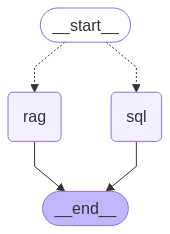

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"query": "Cuantas ayudas hay disponibles?"})

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


{'query': 'Cuantas ayudas hay disponibles?',
 'route': 'sql',
 'response': 'Hay 32 ayudas disponibles.'}

In [21]:
graph.invoke({"query": "Quiero información sobre ayudas a proyectos de i+d"})

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


{'query': 'Quiero información sobre ayudas a proyectos de i+d',
 'route': 'rag',
 'response': '**Información sobre ayudas a proyectos de I+D**\n\nLos proyectos de I+D son iniciativas de investigación y desarrollo empresarial de carácter aplicado que buscan la creación o mejora significativa de un proceso productivo, producto o servicio. Para optar a ayudas, los proyectos deben cumplir con los siguientes requisitos:\n\n- **Innovación tecnológica:** Deben demostrar un aspecto tecnológico diferencial respecto a las tecnologías existentes en el mercado.\n- **Tipo de actividades:** Las actividades pueden abarcar tanto la investigación industrial como el desarrollo experimental.\n- **Presentación:** En general, estos proyectos se presentan por una única empresa; en el caso de referirse a pymes, se aplicarán los criterios establecidos en el Anexo I del Reglamento General de Exención por Categorías (Reglamento (UE)).\n- **Consideraciones ambientales:** No serán susceptibles de ayuda aquellas a

In [22]:
graph.invoke({"query": "Quiero información sobre la ayuda 'proyectos de i+d'"})

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


{'query': "Quiero información sobre la ayuda 'proyectos de i+d'",
 'route': 'rag',
 'response': '**Información sobre la ayuda "proyectos de I+D"**\n\n- **Definición y Objetivo:**  \n  Los proyectos de I+D son iniciativas empresariales de investigación y desarrollo con carácter aplicado. Están destinados a la creación o mejora significativa de procesos productivos, productos o servicios. Esto implica que los proyectos deben presentar un elemento tecnológico diferencial respecto a las tecnologías existentes en el mercado.\n\n- **Ámbito de Actividades:**  \n  Pueden comprender tanto actividades de investigación industrial como de desarrollo experimental.\n\n- **Beneficiarios:**  \n  La ayuda está dirigida a empresas. En algunos contextos, cuando se hace referencia a "pymes", se entiende a aquellas que cumplen con los requisitos establecidos en regulaciones específicas (por ejemplo, en el Anexo I del Reglamento General de Exención por Categorías).\n\n- **Tipo de Convocatoria (según CDTI):*

In [23]:
graph.invoke({"query": "dame un resumen del documento de la convocatoria para la ayuda 'Proyectos de I + D'"})

INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/o3-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://josrodand-openai.openai.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


{'query': "dame un resumen del documento de la convocatoria para la ayuda 'Proyectos de I + D'",
 'route': 'rag',
 'response': '**Resumen de la convocatoria para la ayuda "Proyectos de I + D":**\n\n- **Objetivo:**  \n  Financiación de proyectos de investigación y desarrollo empresarial de carácter aplicado, destinados a la creación o mejora significativa de procesos productivos, productos o servicios.\n\n- **Características del Proyecto:**  \n  - Deben presentar un componente tecnológico diferencial respecto a las tecnologías existentes en el mercado.  \n  - En algunos casos se fomenta la colaboración con centros y organismos de investigación, incluyendo áreas específicas como la medicina personalizada y terapias emergentes, conforme a las prioridades establecidas en los anexos.\n\n- **Modalidad de la Ayuda:**  \n  - La ayuda se compone de dos tramos: uno reembolsable y otro no reembolsable.  \n  - Se aplican condiciones financieras concretas, incluyendo un tipo de interés fijo que se 

In [1]:
from langchain_aws import ChatBedrock
 
llm = ChatBedrock(
    model_id="us.anthropic.claude-3-haiku-20240307-v1:0",
    region = "us-east-1",    
    model_kwargs=dict(temperature=0)
 
)

In [2]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I am 35 years old."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="Voici la traduction en français :\n\nJ'ai 35 ans.", additional_kwargs={'usage': {'prompt_tokens': 33, 'completion_tokens': 21, 'total_tokens': 54}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'us.anthropic.claude-3-haiku-20240307-v1:0'}, response_metadata={'usage': {'prompt_tokens': 33, 'completion_tokens': 21, 'total_tokens': 54}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'us.anthropic.claude-3-haiku-20240307-v1:0'}, id='run-ec3c6b30-a432-47d5-93e7-90e44b379944-0', usage_metadata={'input_tokens': 33, 'output_tokens': 21, 'total_tokens': 54})